In [1]:
import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
import dask
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import pandas as pd
import datetime


In [2]:
# iclassdir = '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/'
# # terrain_file = f'{iclassdir}corgridded_terrain.c0/CSAPR2_Taranis_Gridded_500m.Terrain_RangeMask.nc'
# # terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2.nc'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
# # stats_file = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1/stats/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
# stats_file = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.test/stats/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
# stats_file3d = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.test/stats/stats_3d_ppi_20181015.0000_20190303.0000.nc'

iclassdir = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/'
terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
stats_file = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
stats_file3d = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/stats_3d_ppi_20181015.0000_20190303.0000.nc'

radar_lat = -32.1264
radar_lon = -64.7284

# figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/'
figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.test/figures/'
os.makedirs(figdir, exist_ok=True)

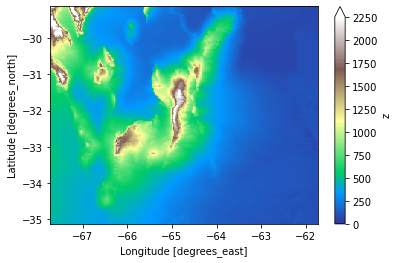

In [3]:
terr = xr.open_dataset(terrain_file)
topoZ = terr['z']
topoLon = terr['x']
topoLat = terr['y']
# topoZ = terr.hgt
# topoLon = terr.longitude
# topoLat = terr.latitude

topoZ.plot(vmin=0, vmax=2250, cmap='terrain')

In [4]:
# Read 2D track data
stats = xr.open_dataset(stats_file)
stats

<xarray.Dataset>
Dimensions:                  (times: 60, tracks: 6895)
Coordinates:
  * tracks                   (tracks) int32 0 1 2 3 4 ... 6891 6892 6893 6894
  * times                    (times) int32 0 1 2 3 4 5 6 ... 54 55 56 57 58 59
Data variables: (12/48)
    lifetime                 (tracks) float64 ...
    basetime                 (tracks, times) datetime64[ns] ...
    core_meanlat             (tracks, times) float32 ...
    core_meanlon             (tracks, times) float32 ...
    core_mean_y              (tracks, times) float32 ...
    core_mean_x              (tracks, times) float32 ...
    ...                       ...
    end_merge_timeindex      (tracks) float64 ...
    end_merge_cloudnumber    (tracks) float64 ...
    merge_tracknumbers       (tracks, times) float64 ...
    split_tracknumbers       (tracks, times) float64 ...
    trackinterruptions       (tracks) float64 ...
    maxrange_flag            (tracks, times) float64 ...
Attributes: (12/13)
    title:                 File containing statistics for each track
    Institution:           Pacific Northwest National Laboratoy
    Contact:               Zhe Feng, zhe.feng@pnnl.gov
    Created_on:            Fri Feb 26 10:40:33 2021
    source:                CSAPR2
    description:           COR
    ...                    ...
    enddate:               20190303.0000
    track_version:         v1.0
    tracknumbers_version:  v1.0
    timegap_hour:          0.5
    time_resolution_hour:  0.25
    pixel_radius_km:       0.5

In [ ]:
# Read 3D data
stats3d = xr.open_dataset(stats_file3d)
# stats3d

In [ ]:
# Combine 2D and 3D datasets by coordinates
stats = xr.combine_by_coords([stats, stats3d], combine_attrs='override')
stats.load()

In [ ]:
xr.set_options(display_style='html')

In [ ]:
stats

In [ ]:
tracks = stats['tracks']
times = stats['times']
time_res = stats.attrs['time_resolution_hour']

lifetime = stats['lifetime'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
maxrange_flag = stats['maxrange_flag']

eth10 = stats['maxETH_10dbz']
eth20 = stats['maxETH_20dbz']
eth30 = stats['maxETH_30dbz']
eth40 = stats['maxETH_40dbz']
eth50 = stats['maxETH_50dbz']

In [ ]:
cell_area.where(lifetime == 1, drop=True).mean(dim='tracks').plot()

In [ ]:
# Get cell initial location
cell_lon0 = cell_lon.isel(times=0)
# Remove NaN
ind = np.where(~np.isnan(cell_lon0))[0]
ntracks = len(ind)
print(f'Number of valid tracks: {ntracks}')

# Subset tracks
lifetime = lifetime.isel(tracks=ind)
start_time = start_time.isel(tracks=ind)
end_time = end_time.isel(tracks=ind)
end_merge_tracknumber = end_merge_tracknumber.isel(tracks=ind)
start_split_tracknumber = start_split_tracknumber.isel(tracks=ind)
cell_lon = cell_lon.isel(tracks=ind)
cell_lat = cell_lat.isel(tracks=ind)
cell_area = cell_area.isel(tracks=ind)
maxrange_flag = maxrange_flag.isel(tracks=ind)
eth10 = eth10.isel(tracks=ind)
eth20 = eth20.isel(tracks=ind)
eth30 = eth30.isel(tracks=ind)
eth40 = eth40.isel(tracks=ind)
eth50 = eth50.isel(tracks=ind)

In [ ]:
# Get track start values
start_maxrange_flag = maxrange_flag.isel(times=0)
start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)

# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration = (lifetime.values / time_res).astype(int)
rangeflag = maxrange_flag.values
celllon = cell_lon.values
celllat = cell_lat.values

end_maxrange_flag = np.ones(ntracks, dtype=int)
end_lon = np.full(ntracks, np.NaN, dtype=float)
end_lat = np.full(ntracks, np.NaN, dtype=float)

# Get track last valid value
for ii in range(0, ntracks):
    # Get duration for the track
    iduration = duration[ii]
    # Get valid values for the track
    imaxrangeflag = rangeflag[ii,0:iduration]
    icell_lon = celllon[ii,0:iduration]
    icell_lat = celllat[ii,0:iduration]
    
    # Get last value from the track
    end_maxrange_flag[ii] = imaxrangeflag[-1]
    end_lon[ii] = icell_lon[-1]
    end_lat[ii] = icell_lat[-1]

In [ ]:
# Get track start/end hour
start_hour = start_time.dt.hour
end_hour = end_time.dt.hour

# Find tracks not end with merge or not start with split
nonmerge = np.where(np.isnan(end_merge_tracknumber))[0]
nonsplit = np.where(np.isnan(start_split_tracknumber))[0]
ntracks_nonmerge = len(nonmerge)
ntracks_nonsplit = len(nonsplit)
print(f'Number of non-merge tracks: {ntracks_nonmerge}')
print(f'Number of non-split tracks: {ntracks_nonsplit}')

nonsplit_in = np.where(np.isnan(start_split_tracknumber) & (start_maxrange_flag == 1))[0]
nonmerge_in = np.where(np.isnan(end_merge_tracknumber) & (end_maxrange_flag == 1))[0]
ntracks_nonsplit_in = len(nonsplit_in)
ntracks_nonmerge_in = len(nonmerge_in)
print(f'Number of non-split tracks within max range: {ntracks_nonsplit_in}')
print(f'Number of non-merge tracks within max range: {ntracks_nonmerge_in}')

merge = np.where(end_merge_tracknumber > 0)[0]
split = np.where(start_split_tracknumber > 0)[0]
ntracks_merge = len(merge)
ntracks_split = len(split)
print(f'Number of merge tracks: {ntracks_merge}')
print(f'Number of split tracks: {ntracks_split}')

In [ ]:
# Get initiation and time
hour_bin = np.arange(0, 25, 1)
hist_starthour, bins = np.histogram(start_hour.isel(tracks=nonmerge), bins=hour_bin, range=(0,24), density=False)
hist_starthour_in, bins = np.histogram(start_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

hist_endhour, bins = np.histogram(end_hour.isel(tracks=nonmerge), bins=hour_bin, range=(0,24), density=False)
hist_endhour_in, bins = np.histogram(end_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

# Convert to local time (UTC-3)
hist_starthour_LT = np.roll(hist_starthour, -3)
hist_starthour_in_LT = np.roll(hist_starthour_in, -3)

hist_endhour_LT = np.roll(hist_endhour, -3)
hist_endhour_in_LT = np.roll(hist_endhour_in, -3)

In [ ]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(1, 2, figsize=[15,5], dpi=100)

ax1 = axes[0]
ax1.plot(hour_bin[:-1], hist_starthour_LT, label='All tracks')
ax1.plot(hour_bin[:-1], hist_starthour_in_LT, label='In range tracks')
ax1.legend()
ax1.grid(ls='--')
ax1.set_title('(a) Cell Track Start Times', loc='left')
ax1.set_ylabel('Number of Tracks')
ax1.set_xlabel('Local Time (hour)')
ax1.set_ylim(100, 300)

ax2 = axes[1]
ax2.plot(hour_bin[:-1], hist_endhour_LT, label='All tracks')
ax2.plot(hour_bin[:-1], hist_endhour_in_LT, label='In range tracks')
ax2.legend()
ax2.grid(ls='--')
ax2.set_title('(b) Cell Track End Times', loc='left')
ax2.set_ylabel('Number of Tracks')
ax2.set_xlabel('Local Time (hour)')
ax2.set_ylim(100, 300)

fig.tight_layout()

In [ ]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Helvetica'
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), dpi=100)

# ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('Lifetime (hr)', fontsize=18)
ax1.set_ylabel('Number', fontsize=18)
ax1.hist(lifetime, bins=np.arange(21)*0.25, density=False, label='All Tracks', width=0.1, alpha=0.6)
ax1.hist(lifetime.isel(tracks=nonmerge), bins=np.arange(21)*0.25, density=False, label='Non-merge Tracks', width=0.2, alpha=0.6)
ax1.legend()
ax1.set_xlim(0, 5)
ax1.set_title('C-SAPR2 Cell Lifetimes', fontsize=18)
ax1.grid()
ax1.set_yscale('log')

In [ ]:
# quantiles = [50,75,90,95]

In [ ]:
# idx = np.where((lifetime == 1) & (np.isnan(end_merge_tracknumber)))[0]
# print(len(idx))
# max_dbz_dur1 = stats.max_reflectivity.sel(tracks=idx)
# max_dbz_dur1_pts = np.nanpercentile(max_dbz_dur1, quantiles, axis=0).transpose()

In [ ]:
# lifetime.shape, end_merge_tracknumber.shape

In [ ]:
# max_dbz1 = max_dbz_dur1.mean(dim='tracks')
# max_dbz1.sel(z=1000).plot()

In [ ]:
# stats.max_reflectivity.where(lifetime == 1).mean(dim='tracks').sel(z=1000).plot()

In [ ]:
quantiles = [0.5,0.75,0.9,0.95]
max_dbz_dur1_pts = stats.max_reflectivity.where(lifetime == 1).quantile(quantiles, dim='tracks')

In [ ]:
max_dbz_dur2_pts = stats.max_reflectivity.where(lifetime == 2).quantile(quantiles, dim='tracks')
max_dbz_dur3_pts = stats.max_reflectivity.where(lifetime == 3).quantile(quantiles, dim='tracks')

In [ ]:
max_dbz_dur1_pts.sel(quantile=0.9).isel(times=slice(0,20)).transpose().plot(vmin=0, vmax=60, cmap='jet')

In [ ]:
max_dbz_dur2_pts.sel(quantile=0.9).isel(times=slice(0,20)).transpose().plot(vmin=0, vmax=60, cmap='jet')

In [ ]:
max_dbz_dur3_pts.sel(quantile=0.9).isel(times=slice(0,20)).transpose().plot(vmin=0, vmax=60, cmap='jet')

In [ ]:
height = stats.z / 1000.